In [1]:
import os
import json
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

class OCTDataset(Dataset):
    def __init__(self, root_dir, indices=None, train=True, is_gentuity=False, transform=None):
        
        self.root_dir = Path(root_dir)
        self.train = train
        self.is_gentuity = is_gentuity
        self.transform = transform
        
        if self.is_gentuity:
            # Gentuity dataset has separate train and test folders
            split_dir = "train" if self.train else "test"
            self.images_dir = self.root_dir / split_dir / "images"
            self.masks_dir = self.root_dir / split_dir / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        else:
            # Terumo dataset has only train data
            self.images_dir = self.root_dir / "train" / "images"
            self.masks_dir = self.root_dir / "train" / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        
        # Filter image paths using indices if provided
        if indices is not None:
            self.samples = [self.samples[i] for i in indices]
        
        else:
            self.samples = sorted(self.images_dir.glob("*.tiff"))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")  # Keep it as a PIL Image
        
        # Load the corresponding mask
        mask_path = self.masks_dir / f"{image_path.stem}.json"
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
        
        # Create a binary mask (0 and 1 values)
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # image.size gives (width, height)
        for coord in mask_data["mask"]:
            x, y = coord
            if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
                mask[x, y] = 1
        
        mask = Image.fromarray(mask)
        
        # Apply the transformation if available
        if self.transform:
            # Convert image and mask to Tensor
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Add channel dimension for mask
        mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed

        unique_id = mask_data["unique_id"]
        
        return image, mask, image_path.stem, unique_id  # Returning image filename too

In [2]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute the attention weights
        attention = self.sigmoid(self.conv2(self.sigmoid(self.conv1(x))))
        return x * attention  # Element-wise multiplication

# Define a large U-Net model with Attn
class Net(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, initial_filters=64):
        super(Net, self).__init__()

        self.encoder1 = self.conv_block(input_channels, initial_filters)
        self.encoder2 = self.conv_block(initial_filters, initial_filters * 2)
        self.encoder3 = self.conv_block(initial_filters * 2, initial_filters * 4)
        self.encoder4 = self.conv_block(initial_filters * 4, initial_filters * 8)
        self.encoder5 = self.conv_block(initial_filters * 8, initial_filters * 16)

        self.pool = nn.MaxPool2d(2)

        # Adjusting channels to match attention input
        self.upconv5 = nn.ConvTranspose2d(initial_filters * 16, initial_filters * 8, kernel_size=2, stride=2)
        self.attn5 = AttentionBlock(initial_filters * 16)  # Updated input channels
        self.decoder5 = self.conv_block(initial_filters * 16, initial_filters * 8)

        self.upconv4 = nn.ConvTranspose2d(initial_filters * 8, initial_filters * 4, kernel_size=2, stride=2)
        self.attn4 = AttentionBlock(initial_filters * 8)  # Updated input channels
        self.decoder4 = self.conv_block(initial_filters * 8, initial_filters * 4)

        self.upconv3 = nn.ConvTranspose2d(initial_filters * 4, initial_filters * 2, kernel_size=2, stride=2)
        self.attn3 = AttentionBlock(initial_filters * 4)  # Updated input channels
        self.decoder3 = self.conv_block(initial_filters * 4, initial_filters * 2)

        self.upconv2 = nn.ConvTranspose2d(initial_filters * 2, initial_filters, kernel_size=2, stride=2)
        self.attn2 = AttentionBlock(initial_filters * 2)  # Updated input channels
        self.decoder2 = self.conv_block(initial_filters * 2, initial_filters)

        self.final_conv = nn.Conv2d(initial_filters, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        e5 = self.encoder5(self.pool(e4))

        # Decoding path with skip connections and attention
        d5 = torch.cat((self.upconv5(e5), e4), dim=1)
        d5 = self.attn5(d5)  # Apply attention
        d5 = self.decoder5(d5)

        d4 = torch.cat((self.upconv4(d5), e3), dim=1)
        d4 = self.attn4(d4)  # Apply attention
        d4 = self.decoder4(d4)

        d3 = torch.cat((self.upconv3(d4), e2), dim=1)
        d3 = self.attn3(d3)  # Apply attention
        d3 = self.decoder3(d3)

        d2 = torch.cat((self.upconv2(d3), e1), dim=1)
        d2 = self.attn2(d2)  # Apply attention
        d2 = self.decoder2(d2)

        # Final output layer
        out = self.final_conv(d2)

        return torch.sigmoid(out)  # Assuming binary segmentation

def dice_loss(pred, target, smooth=1.0):
    intersection = torch.sum(pred * target)
    return 1 - (2. * intersection + smooth) / (torch.sum(pred) + torch.sum(target) + smooth)

In [3]:
from tqdm import tqdm
import torch.optim as optim

root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare datasets for the fold
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Initialize model with the hyperparameters from the config
net = Net().to(device)

# Define loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Split the dataset into training and validation sets
dataset = OCTDataset(root_dir, transform=transform)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=2, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

epochs = 2

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_pixels = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for images, masks, _, _ in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

        # Calculate training accuracy (pixel-wise accuracy)
        pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
        correct_train_predictions += torch.sum(pred == masks).item()
        total_train_pixels += masks.numel()

        progress_bar.set_postfix(loss=loss.item())

    # Calculate training loss and accuracy for the epoch
    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = correct_train_predictions / total_train_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    net.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_pixels = 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for images, masks, _, _ in tqdm(valloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = net(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Calculate validation accuracy (pixel-wise accuracy)
            pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
            correct_val_predictions += torch.sum(pred == masks).item()
            total_val_pixels += masks.numel()

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(valloader.dataset)
    val_accuracy = correct_val_predictions / total_val_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/2], Training Loss: 0.9985, Training Accuracy: 0.7702


Epoch [1/2], Validation Loss: 0.9981, Validation Accuracy: 0.8715


Epoch [2/2], Training Loss: 0.9980, Training Accuracy: 0.8810


Epoch [2/2], Validation Loss: 0.9979, Validation Accuracy: 0.8807


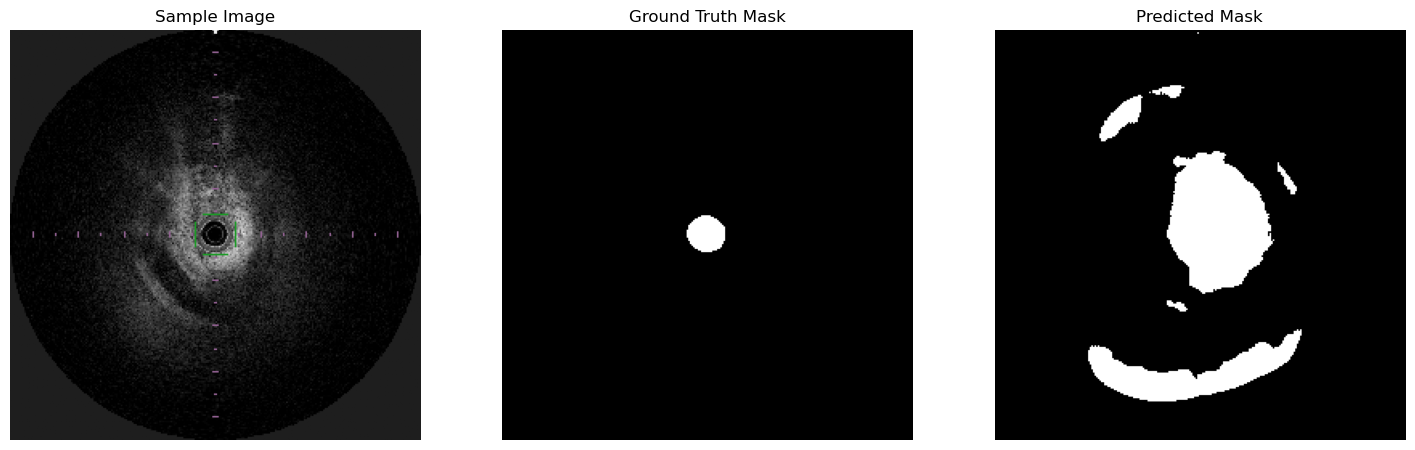

In [5]:
# Set the model to evaluation mode
net.eval()

# Load a sample image from the dataset
sample_image, sample_mask, _, _ = dataset[0]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = net(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()

In [84]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch
from tqdm import tqdm

def train_model(config):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    net = Net().to(device)

    # Select optimizer based on the configuration
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    if config["smoke_test"]:
        # Split the dataset into training and validation sets
        root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"
        dataset = OCTDataset(root_dir, transform=transform)
        val_size = int(0.1 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        trainloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
        valloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    else:
        print("Training on full dataset")

    best_val_loss = float("inf")
    epochs = config["epochs"]
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        epoch_steps= 0

        for i, data in enumerate(trainloader):
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            epoch_steps += 1
            if i % 10 == 9:  # print every 10 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                loss.item()))


        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

        # Validation phase
        net.eval()
        val_loss = 0.0

        with torch.no_grad():  # No need to calculate gradients during validation
            for data in valloader:
                images, masks, _, _ = data
                images, masks = images.to(device), masks.to(device)

                outputs = net(images)
                prediction = (outputs > 0.5).float()
                loss = dice_loss(prediction, masks)
                val_loss += loss.item() * images.size(0)
        
        # Calculate validation loss and accuracy
        val_loss = val_loss / len(valloader.dataset)
        
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Validation loss improved to {val_loss:.4f}. Saving checkpoint.")
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (net.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"loss": val_loss, "accuracy": 1 - val_loss},
                    checkpoint=checkpoint,
                )
        else:
            print(f"Validation loss did not improve. Best so far: {best_val_loss:.4f}")
        
    print("Finished Training")

def test_best_model(best_result):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    best_trained_model = Net().to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
    best_trained_model.load_state_dict(model_state)

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"

    test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
    testloader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in testloader:
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            outputs = net(images)
            predicted = (outputs > 0.5).float()
            loss = dice_loss(predicted, masks)
            total_loss += loss.item() * images.size(0)

    # Calculate average loss and accuracy
    total_loss /= len(testloader.dataset)
    accuracy = 1 - loss

    print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [85]:
from ray.tune.search.optuna import OptunaSearch

# Custom function to shorten trial directory names
def trial_dirname_creator(trial):
    # Shorten the trial name to only include key parameters
    return f"trial_{trial.trial_index}_lr={trial.config['lr']:.1e}_opt={trial.config['optimizer']}_bs={trial.config['batch_size']}"

def main(num_samples, gpus_per_trial, epochs, smoke_test):
    config = {
        "lr": 1e-4,
        "epochs": epochs,
        "smoke_test": smoke_test,
        "batch_size": tune.choice([2]),
        "optimizer": tune.choice(["Adam", "SGD", "RMSprop"]),
    }

    scheduler = ASHAScheduler(
        max_t=config["epochs"],
        grace_period=1,
        reduction_factor=2
    )

    algo = OptunaSearch()

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=trial_dirname_creator,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=3, gpus_per_trial=1, epochs=5, smoke_test=True)

(train_model pid=2628) [1,    10] loss: 1.000
(train_model pid=2628) [1,    20] loss: 0.999
(train_model pid=2628) [1,    30] loss: 1.000
(train_model pid=2628) [1,    40] loss: 1.000
(train_model pid=2628) [1,    50] loss: 0.999
(train_model pid=2628) [1,    60] loss: 0.998
(train_model pid=2628) [1,    70] loss: 0.999
(train_model pid=2628) [1,    80] loss: 0.998
(train_model pid=2628) Epoch [1/5], Training Loss: 0.9993
(train_model pid=2628) Epoch [1/5], Validation Loss: 0.9992
(train_model pid=2628) Validation loss improved to 0.9992. Saving checkpoint.


(train_model pid=2628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_2024-11-23_15-51-07/ebc9d6d7_lr=1.0e-04_opt=SGD/checkpoint_000000)


(train_model pid=2628) [2,    10] loss: 0.999
(train_model pid=2628) [2,    20] loss: 0.999
(train_model pid=2628) [2,    30] loss: 0.999
(train_model pid=2628) [2,    40] loss: 0.999
(train_model pid=2628) [2,    50] loss: 0.999
(train_model pid=2628) [2,    60] loss: 1.000
(train_model pid=2628) [2,    70] loss: 0.999
(train_model pid=2628) [2,    80] loss: 0.999
(train_model pid=2628) Epoch [2/5], Training Loss: 0.9993
(train_model pid=2628) Epoch [2/5], Validation Loss: 0.9992
(train_model pid=2628) Validation loss did not improve. Best so far: 0.9992
(train_model pid=2628) [3,    10] loss: 0.999
(train_model pid=2628) [3,    20] loss: 0.998
(train_model pid=2628) [3,    30] loss: 0.999
(train_model pid=2628) [3,    40] loss: 0.999
(train_model pid=2628) [3,    50] loss: 0.999
(train_model pid=2628) [3,    60] loss: 1.000
(train_model pid=2628) [3,    70] loss: 0.998
(train_model pid=2628) [3,    80] loss: 0.999
(train_model pid=2628) Epoch [3/5], Training Loss: 0.9993
(train_model

2024-11-23 15:53:38,001	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_ebc9d6d7
Traceback (most recent call last):
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\_private\worker.py", line 2656, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johan\anaconda3\e

(train_model pid=17064) [1,    10] loss: 0.997
(train_model pid=17064) [1,    20] loss: 0.999


2024-11-23 15:53:56,583	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-23 15:53:56,598	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/johan/ray_results/train_model_2024-11-23_15-51-07' in 0.0140s.


(train_model pid=17064) [1,    30] loss: 0.998
(train_model pid=17064) [1,    40] loss: 0.999
(train_model pid=17064) [1,    50] loss: 0.999


2024-11-23 15:54:06,709	ERROR tune.py:1037 -- Trials did not complete: [train_model_ebc9d6d7]
2024-11-23 15:54:06,710	INFO tune.py:1041 -- Total run time: 179.26 seconds (169.11 seconds for the tuning loop).
2024-11-23 15:54:06,711	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/johan/ray_results/train_model_2024-11-23_15-51-07", trainable=...)


ValueError: No experiment snapshot file of form 'experiment_state-*.json' was found at: (local, C:/Users/johan/ray_results/train_model_2024-11-23_15-51-07)
Please check if you specified the correct experiment path, which should be a combination of the `storage_path` and `name` specified in your run.

Loading results from C:\Users\johan\ray_results\train_model_2024-11-23_15-39-59...
No errors!
Number of results: 3
Trial #0 finished successfully with a loss of: 0.9924745029873319, batch size: 2
Trial #1 finished successfully with a loss of: 0.9939601156446669, batch size: 2
Trial #2 finished successfully with a loss of: 0.9984577894210815, batch size: 2
Shortest training time: 28.95922303199768
Longest training time: 67.63923478126526


Text(0, 0.5, 'Loss')

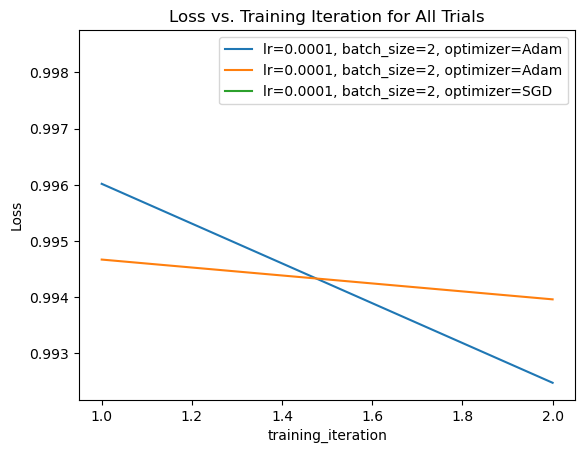

In [80]:
storage_path = r"C:\Users\johan\ray_results"
exp_name = "train_model_2024-11-23_15-39-59"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=train_model)
result_grid = restored_tuner.get_results()

# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a loss of: {result.metrics['loss']}, "
        f"batch size: {result.config['batch_size']}"
    )

results_df = result_grid.get_dataframe()
results_df[["training_iteration", "loss"]]

print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.4f}, batch_size={result.config['batch_size']}, optimizer={result.config['optimizer']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, label=label)
ax.set_title("Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Loss")

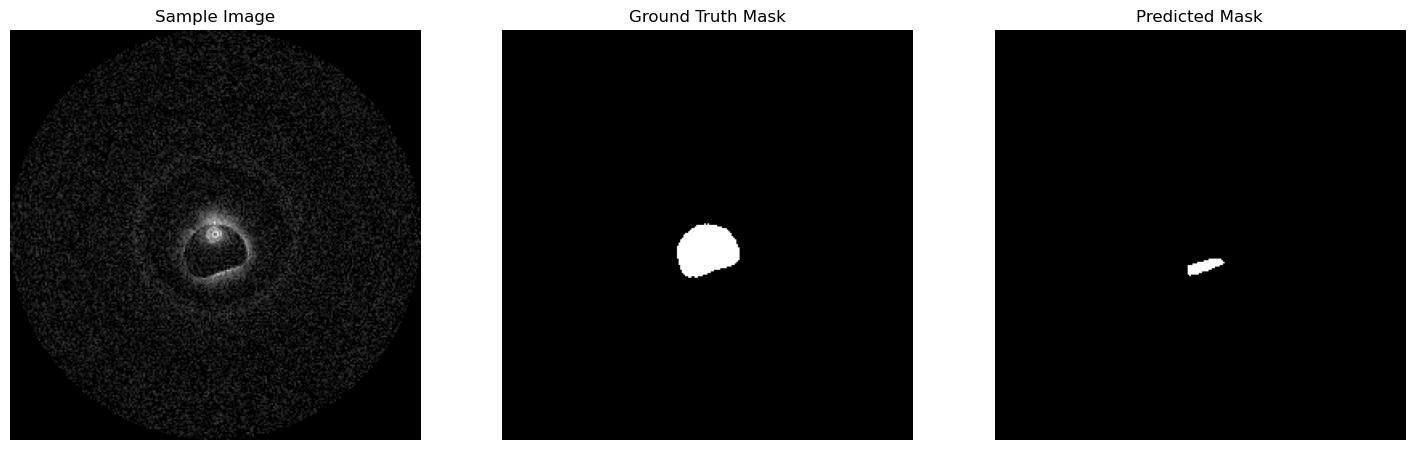

In [83]:
# Load the best model
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

best_trained_model = Net().to(device)

checkpoint_path = r"C:\Users\johan\ray_results\train_model_2024-11-23_15-39-59\train_model_bf6e1dab_1_batch_size=2,epochs=5,lr=0.0001,optimizer=Adam,smoke_test=True_2024-11-23_15-39-59\checkpoint_000001\checkpoint.pt"

model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
best_trained_model.load_state_dict(model_state)

# Set the model to evaluation mode
best_trained_model.eval()

# Load a sample image from the test dataset
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])
test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
random_indices = np.random.choice(len(test_dataset), 1, replace=False)
sample_image, sample_mask, _, _ = test_dataset[random_indices[0]]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = best_trained_model(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()